In [17]:
# Import all the necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV

In [18]:
# Reset pseudo random number generator so that the results are reproducible.
seed = 42
np.random.seed(seed)

## Generate target function and its noisy version.

In [19]:
# Sets the number of examples.
N = 30

# Attribute.
x = np.sort(2*np.random.rand(N, 1) - 1, axis=0)

# Target function.
y = 1 + 0.5*x + 2*(x**2)

# Noisy function.
y_noisy = y + 0.3*np.random.randn(N, 1)

# Validation dataset.
Ntest = 100
x_test = np.linspace(-1, 1, Ntest).reshape(Ntest, 1)
y_test = 1 + 0.5*x_test + 2*(x_test**2) + 0.3*np.random.randn(Ntest, 1)

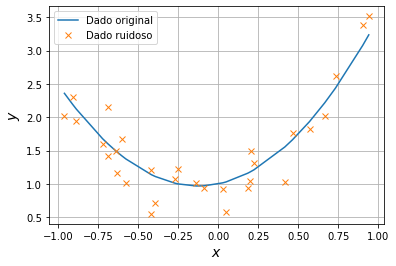

In [20]:
# Plot original data versus noisy version.
plt.plot(x, y, label='Dado original')
plt.plot(x, y_noisy, 'x', label='Dado ruidoso')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
#plt.savefig("target_function.png", dpi=600)
#Show the plot.
plt.show()

In [21]:
print('Valor médio:', np.mean(y_noisy))

Valor médio: 1.530915117847102


## Define the polinomial order

Escolhemos um polinômio de ordem maior do que a ordem por trás do modelo gerador, ou seja, ele tem mais flexibilidade do que o necessário.

In [22]:
# Polynomial order.
model_order = 15

## Define the regularization factor

In [23]:
# Regularization factor.
lambdas = [0, 0.0076, 1]

## SciKit-Learn solution

Lambda: 0.0000e+00:
[1.53091512]
[-3.26619148e-01  6.26027965e+00  9.11715885e+00 -8.93092859e+01
 -9.13730327e+01  5.26147653e+02  5.43742416e+02 -1.51291387e+03
 -1.71566113e+03  2.27078228e+03  2.80890380e+03 -1.70290215e+03
 -2.25122856e+03  5.02976634e+02  6.97684255e+02]
---------------------------------------------
Lambda: 7.6000e-03:
[1.53091512]
[ 0.21805523  0.60770517  0.09951701  0.02276031  0.01384661  0.
  0.00884529  0.          0.00634401 -0.          0.00464897 -0.
  0.00366414 -0.          0.00310918]
---------------------------------------------
Lambda: 1.0000e+00:
[1.53091512]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
---------------------------------------------


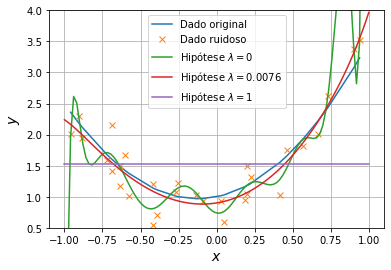

In [24]:
include_bias = True

# Plot original data versus noisy version.
plt.plot(x, y, label='Dado original')
plt.plot(x, y_noisy, 'x', label='Dado ruidoso')
for i in range(0,len(lambdas)):

    # Instantiate a polynomial with the given degree.
    poly = PolynomialFeatures(degree=model_order, include_bias=include_bias)
    # Instantiate a scaler that will standardize the features.
    scaler = StandardScaler()
    # Instantiate a Ridge regressor.
    reg = Lasso(alpha=lambdas[i], tol=1, random_state=seed) if lambdas[i] > 0 else LinearRegression()
    # Create a pipeline of actions.
    model = Pipeline([
        ("poly", poly),
        ("scaler", scaler),
        ("reg", reg),
    ])
    # Train model.
    model.fit(x, y_noisy)
    # Print coefs
    print('Lambda: %1.4e:' % (lambdas[i]))
    print(model.named_steps['reg'].intercept_)
    if lambdas[i] > 0:
        print(model.named_steps['reg'].coef_[1:model_order+1])
    else:
        print(model.named_steps['reg'].coef_[0, 1:model_order+1])
    print('---------------------------------------------')
    # Predict.
    y_test_regul = model.predict(x_test)
    # Plot prediction.
    plt.plot(x_test, y_test_regul, label='Hipótese $\lambda=$'+str(lambdas[i]))
    
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
plt.ylim(0.5,4)
# Save figure
#plt.savefig("lasso_regression.png", dpi=600)
#Show the plot.
plt.show()

In [25]:
include_bias = True

M = 5000
lambdas = np.linspace(1e-4,1, M)

a_hist = np.zeros((model_order, M))
norm_hist = np.zeros((1, M))
error_test = []

for i in range(0,len(lambdas)):
    # Instantiate a polynomial with the given degree.
    poly_features = PolynomialFeatures(degree=model_order, include_bias=include_bias)
    # Instantiate a scaler that will standardize the features.
    std_scaler = StandardScaler()
    # Instantiate a Ridge regressor.
    reg = Lasso(alpha=lambdas[i], tol=1, random_state=seed) if lambdas[i] > 0 else LinearRegression()
    # Create a pipeline of actions.
    model = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("reg", reg),
    ])
    # Train model.
    model.fit(x, y_noisy)
    a = model.named_steps['reg'].coef_[1:model_order+1]
    a_hist[:,i] = a
    norm_hist[:,i] = np.linalg.norm(a, ord=1)
    # Predict.
    y_test_regul = model.predict(x_test)
    error_test.append((mean_squared_error(y_test, y_test_regul)))

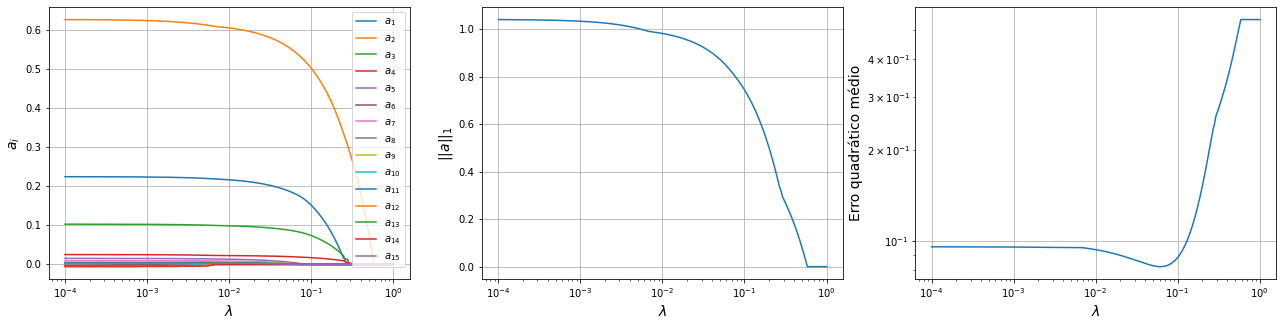

In [26]:
# Create figure.
fig = plt.figure(figsize=(22,5))

# Plot weight.
ax = plt.subplot(1, 3, 1)
for i in range(0,model_order): 
    plt.plot(lambdas, a_hist[i,:], label='$a_{'+str(i+1)+'}$')
plt.xscale('log')
plt.xlabel('$\lambda$', fontsize=14)
plt.ylabel('$a_i$', fontsize=14)
plt.legend(loc='upper right')
plt.grid()
# Save figure
#plt.savefig("lasso_regression_pesos.png", dpi=600)

# Plot norm.
ax = plt.subplot(1, 3, 2)
plt.plot(lambdas, norm_hist[0,:])
plt.xscale('log')
plt.xlabel('$\lambda$', fontsize=14)
plt.ylabel('$||a||_1$', fontsize=14)
plt.grid()
# Save figure
#plt.savefig("lasso_regression_norma.png", dpi=600)

# Plot error.
ax = plt.subplot(1, 3, 3)
plt.plot(lambdas, error_test)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$', fontsize=14)
plt.ylabel('Erro quadrático médio', fontsize=14)
plt.grid()
# Save figure
#plt.savefig("lasso_regression_mse.png", dpi=600)

#Show the plot.
plt.show()

Valores pequenos de $\lambda$ até $1\times10^{-1}$ fazem com que modelo fique próximo da função geradora, após isso, o modelo tende ao valor constante igual à média dos rótulos de treinamento, o que faz o erro aumentar.

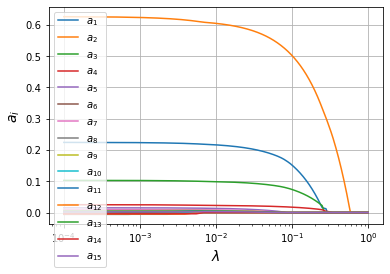

In [11]:
# Plot weight.
for i in range(0,model_order): 
    plt.plot(lambdas, a_hist[i,:], label='$a_{'+str(i+1)+'}$')
plt.xscale('log')
plt.xlabel('$\lambda$', fontsize=14)
plt.ylabel('$a_i$', fontsize=14)
plt.legend(loc='upper left')
plt.grid()
#Show the plot.
plt.show()

### Finding the best $\lambda$ for LASSO

In [27]:
M = 1000
alphas = np.logspace(-5,2,M)

# Instantiate a polynomial with the given degree.
poly = PolynomialFeatures(degree=model_order, include_bias=include_bias)
# Instantiate a scaler that will standardize the features.
scaler = StandardScaler()
# Instantiate a LASSO regressor.
reg = LassoCV(alphas=alphas, tol=1, random_state=seed)
# Create a pipeline of actions.
clf = Pipeline([
    ("poly", poly),
    ("scaler", scaler),
    ("reg", reg),
])

clf.fit(x, y_noisy.ravel())
clf.score(x, y_noisy.ravel())

0.8763933683078986

In [28]:
clf['reg'].alpha_

0.007225349491787214

In [29]:
alphas = np.linspace(clf['reg'].alpha_/10,clf['reg'].alpha_*10,M)

# Instantiate a polynomial with the given degree.
poly = PolynomialFeatures(degree=model_order, include_bias=include_bias)
# Instantiate a scaler that will standardize the features.
scaler = StandardScaler()
# Instantiate a Ridge regressor cross-validation.
reg = LassoCV(alphas=alphas, tol=1, random_state=seed)
# Create a pipeline of actions.
clf = Pipeline([
    ("poly", poly),
    ("scaler", scaler),
    ("reg", reg),
])

clf.fit(x, y_noisy.ravel())
clf.score(x, y_noisy.ravel())

0.876386318138381

In [30]:
clf['reg'].alpha_

0.007596380952176286

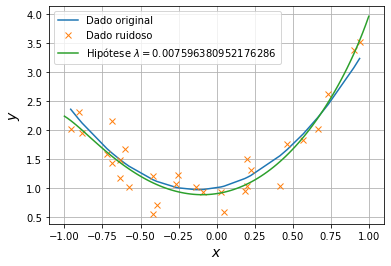

In [31]:
y_test_pred = clf.predict(x_test)

# Plot original data versus noisy version.
plt.plot(x, y, label='Dado original')
plt.plot(x, y_noisy, 'x', label='Dado ruidoso')
plt.plot(x_test, y_test_pred, label='Hipótese $\lambda=$'+str(clf['reg'].alpha_))
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
#plt.axis([-1, 0, 1])
#Show the plot.
plt.show()

### Figures

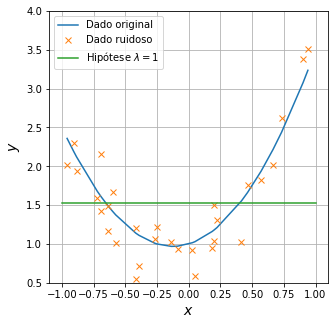

In [40]:
lambdas = 1

include_bias = True

# Plot original data versus noisy version.
plt.figure(figsize=(5,5))
plt.plot(x, y, label='Dado original')
plt.plot(x, y_noisy, 'x', label='Dado ruidoso')
# Instantiate a polynomial with the given degree.
poly = PolynomialFeatures(degree=model_order, include_bias=include_bias)
# Instantiate a scaler that will standardize the features.
scaler = StandardScaler()
# Instantiate a Ridge regressor.
reg = Lasso(alpha=lambdas, tol=1, random_state=seed) if lambdas > 0 else LinearRegression()
# Create a pipeline of actions.
model = Pipeline([
    ("poly", poly),
    ("scaler", scaler),
    ("reg", reg),
])
# Train model.
model.fit(x, y_noisy)
# Predict.
y_test_regul = model.predict(x_test)
# Plot prediction.
plt.plot(x_test, y_test_regul, label='Hipótese $\lambda=$'+str(lambdas))
    
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
plt.ylim(0.5,4)
# Save figure
plt.savefig('lasso_regression_lambda'+str(lambdas)+'.png', dpi=600)
#Show the plot.
plt.show()

In [41]:
include_bias = True

M = 5000
lambdas = np.linspace(1e-4, 1, M)

a_hist = np.zeros((model_order, M))
norm_hist = np.zeros((1, M))
error_test = []

for i in range(0,len(lambdas)):
    # Instantiate a polynomial with the given degree.
    poly = PolynomialFeatures(degree=model_order, include_bias=include_bias)
    # Instantiate a scaler that will standardize the features.
    scaler = StandardScaler()
    # Instantiate a Ridge regressor.
    reg = Lasso(alpha=lambdas[i], tol=1, random_state=seed) if lambdas[i] > 0 else LinearRegression()
    # Create a pipeline of actions.
    model = Pipeline([
        ("poly", poly),
        ("scaler", scaler),
        ("reg", reg),
    ])
    # Train model.
    model.fit(x, y_noisy)
    a = model.named_steps['reg'].coef_[1:model_order+1]
    a_hist[:,i] = a
    norm_hist[:,i] = np.linalg.norm(a, ord=1)
    # Predict.
    y_test_regul = model.predict(x_test)
    error_test.append((mean_squared_error(y_test, y_test_regul)))

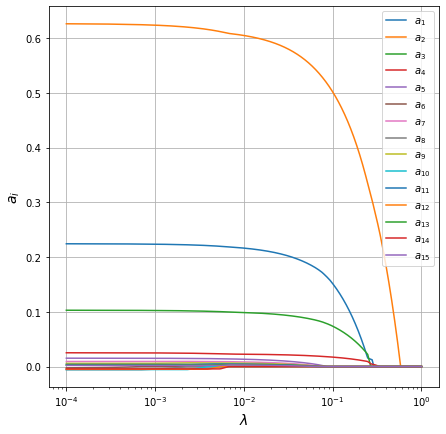

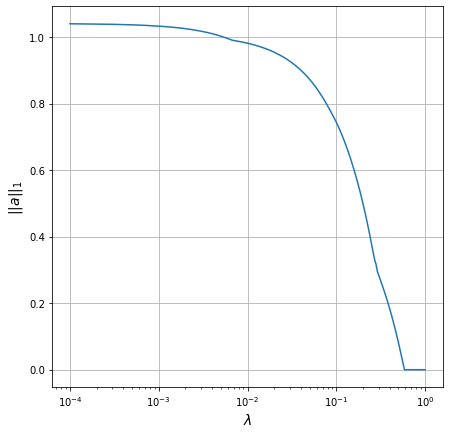

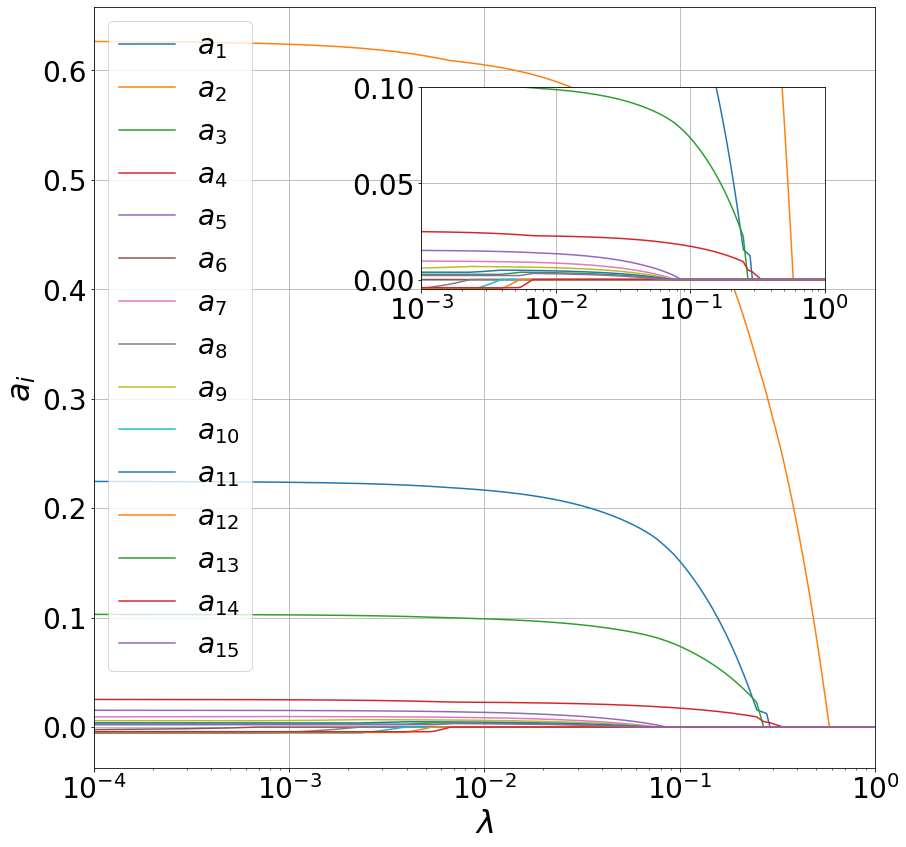

In [43]:
# Create figure.

# Plot weight.
fig = plt.figure(figsize=(7,7))
for i in range(0,model_order): 
    plt.plot(lambdas, a_hist[i,:], label='$a_{'+str(i+1)+'}$')
plt.xscale('log')
plt.xlabel('$\lambda$', fontsize=14)
plt.ylabel('$a_i$', fontsize=14)
plt.legend(loc='upper right')
plt.grid()
# Save figure
#plt.savefig("lasso_regression_pesos.png", dpi=600)

#Show the plot.
plt.show()

# Plot norm.
fig = plt.figure(figsize=(7,7))
plt.plot(lambdas, norm_hist[0,:])
plt.xscale('log')
plt.xlabel('$\lambda$', fontsize=14)
plt.ylabel('$||a||_1$', fontsize=14)
plt.grid()
# Save figure
plt.savefig("lasso_regression_l1_norm.png", dpi=600)

#Show the plot.
plt.show()






# Plot weight.
fig = plt.figure(figsize=(14,14))
for i in range(0,model_order): 
    plt.plot(lambdas, a_hist[i,:], label='$a_{'+str(i+1)+'}$')
plt.tick_params(axis = 'both', which = 'both', labelsize = 28)
plt.xscale('log')
plt.xlabel('$\lambda$', fontsize=32)
plt.ylabel('$a_i$', fontsize=32)
plt.legend(fontsize=28)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=14)
#plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0., fontsize=14)
plt.grid()
plt.xlim(1e-4,1)

left, bottom, width, height = [0.45, 0.6, 0.4, 0.2]
ax1 = fig.add_axes([left, bottom, width, height])
for i in range(0,model_order): 
    ax1.plot(lambdas, a_hist[i,:], label='$a_{'+str(i+1)+'}$')
ax1.tick_params(axis = 'both', which = 'both', labelsize = 28)
ax1.set_xlim(0.001, 1)
ax1.set_ylim(-0.005, 0.1)
plt.xscale('log')
ax1.grid()

# Save figure.
plt.savefig('lasso_regression_weightsv2.png', dpi=600)
# Show the plot.
plt.show()